In [20]:
import sys 
module_path = '../build_bats/bindings/python/'
sys.path.append(module_path)
import oineus as oin
import numpy as np
import scipy.spatial
import matplotlib.pyplot as plt

In [45]:
def compute_ls_dgm1_oineus(f, max_dim = 1, negate=False, wrap=False, as_numpy = True):
    # f: image array
    rp = oin.ReductionParams()
    rp.compute_u = False
    rp.compute_v = False
    rp.clearing_opt = True
    dgms = oin.compute_diagrams_ls(f, negate=negate, wrap=wrap, 
                                    max_dim=max_dim, include_inf_points=False, 
                                    params=rp, dualize=False)
    return dgms.in_dimension(1, False)

In [14]:
import numpy as np
import plotly.graph_objects as go

# Define the function as the sum of two 2D normal distributions
def my_2d_function(x, y, peak1, peak2, std1, std2, height1, height2):
    
    term1 = height1 * np.exp(
        -((x - peak1[0])**2 / (2 * std1[0]**2) + (y - peak1[1])**2 / (2 * std1[1]**2))
    )
    term2 = height2 * np.exp(
        -((x - peak2[0])**2 / (2 * std2[0]**2) + (y - peak2[1])**2 / (2 * std2[1]**2))
    )
    return term1 + term2

# Create a grid of points
x = np.linspace(-10, 10, 100)
y = np.linspace(-10, 10, 100)
x, y = np.meshgrid(x, y)

# Set parameters for the function
peak1 = [-5, -5]
peak2 = [5, 5]
std1 = [1, 1]
std2 = [1, 2]
height1 = 2
height2 = 3
# Calculate function values for each point in the grid
z = my_2d_function(x, y, peak1, peak2, std1, std2, height1, height2)

# Create a 3D surface plot
fig = go.Figure()
fig.add_trace(go.Surface(z=z, x=x, y=y))
# Set axis labels
fig.update_layout(scene=dict(xaxis_title='X', yaxis_title='Y', zaxis_title='Function Value'))
# Show the plot
fig.show()


In [17]:
# create scalar function on 30x30 grid
f = z
fil = oin.get_freudenthal_filtration(data=f, max_dim=2, negate = False, wrap=False, n_threads=-1)
top_opt = oin.TopologyOptimizer(fil)
dgm = top_opt.compute_diagram(include_inf_points=False) # PD

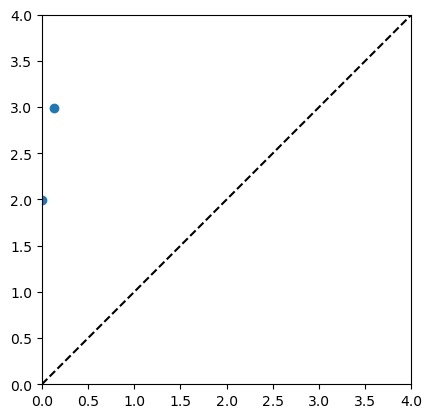

In [25]:
dgm1 = dgm.in_dimension(1)

fig, ax = plt.subplots()
ax.scatter(dgm1[:, 0], dgm1[:, 1])
xbnds, ybnds = [0,4], [0,4]
ax.set_xlim(xbnds)
ax.set_ylim(ybnds)
ax.set_aspect('equal')

# add visual lines
ax.plot(xbnds, ybnds, '--k')

In [81]:
import torch
def flatten_idx_2_2D_idx(k, ymax):
    # Map the compressed 1D index of an image array to 2D index 
    # k: index in compressed array
    # ymax: # of columns of image
    q, mod = divmod(k, ymax) 
    return q, mod


class LevelsetCriticalSimplify(torch.nn.Module):
    def __init__(self, Hdim=1, n = 1):
        super(LevelsetCriticalSimplify, self).__init__()
        self.Hdim = Hdim
        self.num_persis = n+1

    def forward(self, f):
        fnp = f.clone().detach().numpy()
        fil, max_value_vertices = oin.get_freudenthal_filtration_and_critical_vertices(fnp, negate=False,
                                                                                        wrap=False, max_dim=2,
                                                                                        n_threads=8)
        # max_value_vertices stores the maximal vertex index of each simplex
        top_opt = oin.TopologyOptimizer(fil)
        dgm = top_opt.compute_diagram(include_inf_points=False) # PD
        eps = top_opt.get_nth_persistence(self.Hdim, self.num_persis) # choose prominent persistence outside eps
        # find persistence in terms of `indices` of simplex and its filtration `values` 
        indices, values = top_opt.simplify(eps, oin.DenoiseStrategy.BirthBirth, self.Hdim) # matching defined here
        print(indices)
        # find critical sets 
        critical_sets = top_opt.singletons(indices, values)
        # deal with conflict
        crit_indices, crit_values = top_opt.combine_loss(critical_sets, oin.ConflictStrategy.Max)
        crit_indices = np.array(crit_indices, dtype=np.int32) # indices of critical simplices (high dim)
        crit_vertices = max_value_vertices[crit_indices] # indices of vertcies (0-simplex)

        # compute the general loss (sum of singleton losses)
        match_loss =  torch.tensor([.0])
        for i, v in zip(indices, values):
            match_loss += (fil.simplex_value_by_sorted_id(i) - v) ** 2 # not for gradient purpose

        
        if len(crit_vertices) == 0:
            raise RuntimeError("nothing to optimize")
        
        width = f.shape[1]
        crit_loss = .0
        for idx, v in zip(crit_vertices, crit_values):
            i,j = flatten_idx_2_2D_idx(idx, width)
            crit_loss += (f[i,j] - v) ** 2
            
            
        return crit_loss, match_loss

torch_img = torch.tensor(z, requires_grad=True)
loss_func = LevelsetCriticalSimplify(Hdim=1, n = 0)
learning_rate = 0.01
optimizer = torch.optim.SGD([torch_img], lr=learning_rate)
data_list = [z]
try:
    for i in range(5):
        optimizer.zero_grad()
        opt_loss, dgm_loss = loss_func(torch_img)
        opt_loss.backward()
        optimizer.step()
        data_list.append(torch_img.clone().detach().numpy())
except RuntimeError as e:
    print(f"Caught an error: {e}, stop at iter {i}")

[58903, 59202]
[58859, 58862, 58887, 59178, 59188, 59202]
[58874, 59167, 59177, 59196, 59202]
[58855, 59196, 59202]
[58794, 58800, 58808, 58845, 59125, 59155, 59188, 59202]


In [82]:
dgm1 = compute_ls_dgm1_oineus(data_list[1])
dgm1

[(1.816683, 1.818682, birth_index=39100, death_index=58859),
 (1.816683, 1.818682, birth_index=39102, death_index=58862),
 (0.000007, 1.876425, birth_index=23960, death_index=58887),
 (2.745129, 2.772739, birth_index=39554, death_index=59178),
 (2.759115, 2.786893, birth_index=39567, death_index=59188),
 (0.131643, 2.844238, birth_index=35252, death_index=59202)]

In [83]:
# Create a 3D surface plot
fig = go.Figure()
x = np.linspace(-10, 10, 100)
y = np.linspace(-10, 10, 100)
x, y = np.meshgrid(x, y)
fig.add_trace(go.Surface(z=data_list[3], x=x, y=y))
# Set axis labels
fig.update_layout(scene=dict(xaxis_title='X', yaxis_title='Y', zaxis_title='Function Value'))
# Show the plot
fig.show()

## Linear interpolate

In [ ]:
class LevelsetLinearInterpolate(torch.nn.Module):
    def __init__(self, Hdim=1, n = 1):
        super(LevelsetCriticalSimplify, self).__init__()
        self.Hdim = Hdim
        self.num_persis = n

    def forward(self, f):
        fnp = f.clone().detach().numpy()
        fil, max_value_vertices = oin.get_freudenthal_filtration_and_critical_vertices(fnp, negate=False,
                                                                                        wrap=False, max_dim=2,
                                                                                        n_threads=8)
        # max_value_vertices stores the maximal vertex index of each simplex
        top_opt = oin.TopologyOptimizer(fil)
        dgm = top_opt.compute_diagram(include_inf_points=False) # PD
        eps = top_opt.get_nth_persistence(self.Hdim, self.num_persis) # choose prominent persistence outside eps
        # find persistence in terms of `indices` of simplex and its filtration `values` 
        indices, values = top_opt.simplify(eps, oin.DenoiseStrategy.BirthBirth, self.Hdim) # matching defined here
        # find critical sets 
        critical_sets = top_opt.decrease_death(indices, values)
        # deal with conflict
        crit_indices, crit_values = top_opt.combine_loss(critical_sets, oin.ConflictStrategy.Max)
        crit_indices = np.array(crit_indices, dtype=np.int32) # indices of critical simplices (high dim)
        crit_vertices = max_value_vertices[crit_indices] # indices of vertcies (0-simplex)

        # compute the general loss (sum of singleton losses)
        match_loss =  torch.tensor([.0])
        for i, v in zip(indices, values):
            match_loss += (fil.simplex_value_by_sorted_id(i) - v) ** 2 # not for gradient purpose

        
        if len(crit_vertices) == 0:
            raise RuntimeError("nothing to optimize")
        
        width = f.shape[1]
        crit_loss = .0
        for idx, v in zip(crit_vertices, crit_values):
            i,j = flatten_idx_2_2D_idx(idx, width)
            crit_loss += (f[i,j] - v) ** 2
            
            
        return crit_loss, match_loss